# Outline of corrections to SDO/HMI Images

1. **coordinate transformation:** transform from Helioprojective Cartesian coordinates
to Heliographic Carrington coordinates based on observer
2. **spacecraft velocity calculation:** correct for the  velocity of spacecraft relative
to Sun
3. **solar rotation calculation:** account for velocity due to solar rotation as a function of
latitude (based on Snodgrass & Ulrich 1990)
4. **limb darkening correction:** correct for limb darkening in HMI intensity images
5. **unsigned magnetic field strength:** calculate unsigned magnetic field strength by dividing observed
field strength by $ \mu = cos(\theta)$
6. **identify solar regions:** differentiate between quiet Sun, sunspots, faculae/plage regions


In [1]:
import numpy as np

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import matplotlib.pyplot as plt

from scipy import stats

import SolAster.tools.calculation_funcs as sfuncs
import SolAster.tools.lbc_funcs as lbfuncs
import SolAster.tools.coord_funcs as ctfuncs
from SolAster.tools.settings import Parameters

Get HMI data.

In [2]:
# get hmi data products
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2021-01-01T00:00:00'  # start date of query
end_date = '2021-01-02T00:01:00'
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2], cadence)

# print results
print(result)

Results from 3 Providers:

2 Results from the VSOClient:
       Start Time               End Time        ...   Size          Info       
                                                ...  Mibyte                    
----------------------- ----------------------- ... -------- ------------------
2021-01-01 00:00:22.000 2021-01-01 00:00:23.000 ... -0.00098 45sec. Dopplergram
2021-01-02 00:00:22.000 2021-01-02 00:00:23.000 ... -0.00098 45sec. Dopplergram

2 Results from the VSOClient:
       Start Time               End Time        ...   Size          Info       
                                                ...  Mibyte                    
----------------------- ----------------------- ... -------- ------------------
2021-01-01 00:00:22.000 2021-01-01 00:00:23.000 ... -0.00098 45sec. Magnetogram
2021-01-02 00:00:22.000 2021-01-02 00:00:23.000 ... -0.00098 45sec. Magnetogram

2 Results from the VSOClient:
       Start Time               End Time        ...            Info           
  

Download data files, sort, and build map list.

In [3]:
# download results
file_download = Fido.fetch(result)
# convert to map sequence
map_seq = sunpy.map.Map(sorted(file_download))


Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

hmi_v_45s_2021_01_02_00_01_30_tai_dopplergram.fits:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Create map lists based on HMI content.

In [4]:
hmi_vel, hmi_mag, hmi_int \
    = [], [], []
for i, map_obj in enumerate(map_seq):
    if map_obj.meta['content'] == 'DOPPLERGRAM':
        hmi_vel.append(map_obj)
    elif map_obj.meta['content'] == 'MAGNETOGRAM':
        hmi_mag.append(map_obj)
    elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
        hmi_int.append(map_obj)

## Step One: Coordinate Transformations

Apply coordinate transformations for HMI data products where:

<code>x, y, pdim, r, d, mu = coord[i][0], coord[i][1], coord[i][2], coord[i][3], coord[i][4], coord[i][5]</code>

<code>wij, nij, rij = vel_coords[i][0], vel_coords[i][1], vel_coords[i][2]</code>

In [5]:
# get cartesian scales from map
coord = [ctfuncs.coordinates(hmi_vel[i]) for i in range(0, len(hmi_vel))]

# get mu and radius array
vel_coords = [ctfuncs.vel_coords(coord[i][0], coord[i][1], coord[i][2], coord[i][3], hmi_vel[i]) for i in range(0, len(hmi_vel))]

Remove bad mu values from each map.

<code>hmi_vel, hmi_mag, imap = maps[i][0], maps[i][1], maps[i][2]</code>

In [6]:
# fix bad mu values
maps = [ctfuncs.fix_mu(coord[i][5], [hmi_vel[i],  hmi_mag[i],  hmi_int[i]]) for i in range(0, len(hmi_vel))]

# return maps to original lists
hmi_vel = [maps[i][0] for i in range(0, len(hmi_vel))]
hmi_mag = [maps[i][1] for i in range(0, len(hmi_vel))]
hmi_int = [maps[i][2] for i in range(0, len(hmi_vel))]

## Step Two: Calculate Spacecraft Velocity

Calculate relative positions.

<code>deltaw, deltan, deltar, dij = delta[i][0], delta[i][1], delta[i][2], delta[i][3]</code>

In [7]:
delta = [sfuncs.rel_positions(vel_coords[i][0], vel_coords[i][1], vel_coords[i][2], hmi_vel[i]) for i in range(0, len(hmi_vel))]

Calculate spacecraft velocity.

In [8]:
vsc = [sfuncs.spacecraft_vel(delta[i][0], delta[i][1], delta[i][2], delta[i][3], hmi_vel[i]) for i in range(0, len(hmi_vel))]

## Step Three: Calculate Velocity due to Solar Rotation

Optimized parameters for calculation of solar rotation.

In [9]:
a_parameters = [Parameters.a1, Parameters.a2, Parameters.a3]

Calculation of solar rotation velocity.

In [10]:
vrot = [sfuncs.solar_rot_vel(vel_coords[i][0], vel_coords[i][1], vel_coords[i][2], delta[i][0], delta[i][1], delta[i][2],
                             delta[i][3], hmi_vel[i], a_parameters) for i in range(0, len(hmi_vel))]

Calculate corrected velocity.

In [11]:
# subtract vsc and vrot from the Doppler images
corrected_vel = [hmi_vel[i].data - np.real(vsc[i]) - np.real(vrot[i]) for i in range(0, len(hmi_vel))]

Create list of Sunpy map objects with corrected velocity data.

In [12]:
map_vel_cor = [sfuncs.corrected_map(corrected_vel[i], hmi_vel[i], map_type='Corrected-Dopplergram',
                                    frame=frames.HeliographicCarrington) for i in range(0, len(hmi_vel))]

Compare original and corrected velocity maps.

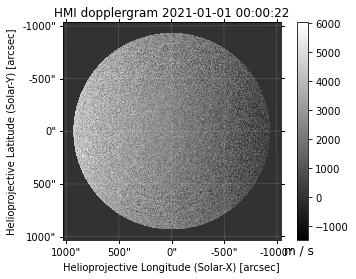

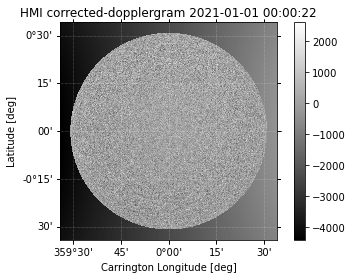

In [13]:
# plot original map
hmi_vel[0].peek()

# plot corrected map
map_vel_cor[0].peek()


## Step Four: Limb Darkening Correction

Equation for limb-brightening:
$ L_{ij} = 1 - u_2 - v_2 + u_2 cos \theta + v_2 cos^2 \theta $

Coefficient values from Astrophysical Quantities by Allen (1973).

Calculate correction polynomial.

In [14]:
Lij = [lbfuncs.limb_polynomial(hmi_int[i]) for i in range(0, len(hmi_int))]

Calculate corrected intensity.

In [15]:
Iflat = [hmi_int[i].data/Lij[i] for i in range(0, len(hmi_int))]

Create list of Sunpy map objects with corrected intensity data.

In [16]:
map_int_cor = [sfuncs.corrected_map(Iflat[i], hmi_int[i], map_type='Corrected-Intensitygram', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_int))]

Compare original and corrected intensity maps.

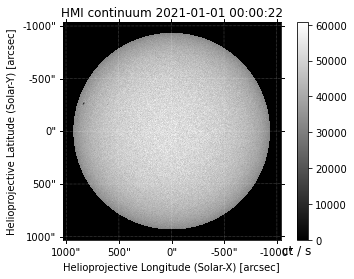

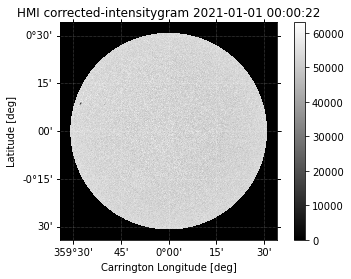

In [17]:
# plot original map
hmi_int[0].peek()

# plot corrected map
map_int_cor[0].peek()

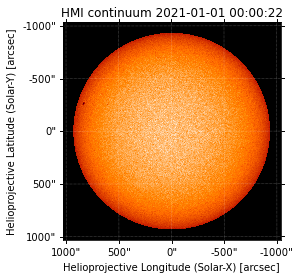

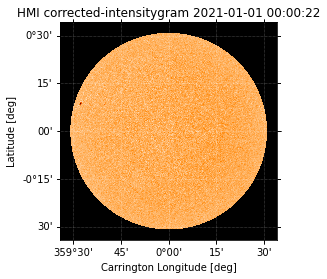

In [18]:
int_map = hmi_int[0]
cont_map = plt.get_cmap('hinodesotintensity')
int_map.plot_settings['cmap'] = cont_map
int_map.plot()
plt.show()

int_map = map_int_cor[0]
cont_map = plt.get_cmap('hinodesotintensity')
int_map.plot_settings['cmap'] = cont_map
int_map.plot()
plt.show()

## Step Five: Unsigned Magnetic Field Strength

We calculate radial unsigned magnetic field strength and set pixels with an
observed magnetic field below the noise value equal to zero.

The noise level used is from Yeo et al. 2013, and is 8 Gauss.

<code>Bobs, Br = corrected_mag[0], corrected_mag[1]</code>

In [19]:
# magnetic noise level
B_noise = Parameters.B_noise

# calculate unsigned field strength
corrected_mag = [sfuncs.mag_field(coord[i][5], hmi_mag[i], B_noise) for i in range(0, len(hmi_mag))]

Create list of Sunpy map objects with corrected observed and radial magnetic data.

In [20]:
# observed magnetic data
map_mag_obs = [sfuncs.corrected_map(corrected_mag[i][0], hmi_mag[i], map_type='Corrected-Magnetogram', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_mag))]

# radial magnetic data
map_mag_cor = [sfuncs.corrected_map(corrected_mag[i][1], hmi_mag[i], map_type='Corrected-Magnetogram', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_mag))]

Compare original and corrected magnetic maps.

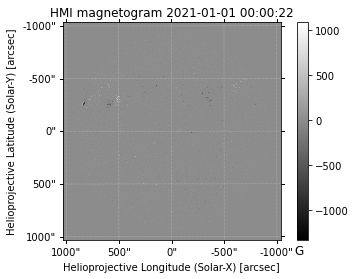

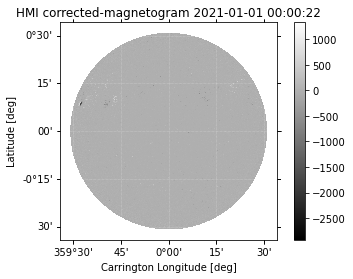

In [21]:
# plot original map
hmi_mag[0].peek()

# plot corrected map
map_mag_cor[0].peek()


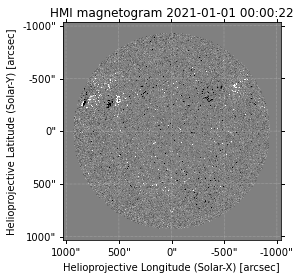

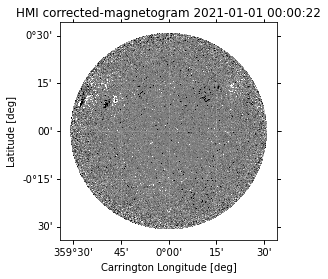

In [22]:
mag_map = hmi_mag[0]
mag_map.plot_settings['norm'] = plt.Normalize(-100, 100)
mag_map.plot()
plt.show()

mag_map = map_mag_cor[0]
mag_map.plot_settings['norm'] = plt.Normalize(-100, 100)
mag_map.plot()
plt.show()

## Step Six: Identification of Solar Regions

### Part One: Magnetic Thresholding

Differentiate between active Sun and quiet Sun.
Magnetic thresholding method used from Yeo et al. 2013 where
$ B_{r, thresh} = 24G / \mu $ .

Magnetic threshold and mu cutoff values.
Automatically throw everything where $ \mu < 0.1 $ out, for magnetic thresholding we also
remove $ \mu < 0.3 $ due to correction for radial magnetic field strength.

In [23]:
# magnetic threshold value (G) from Yeo et. al. 2013
Br_cutoff = Parameters.Br_cutoff

# mu cutoff value
mu_cutoff = Parameters.mu_cutoff

For weighting, we return an active weights array (active = 1) and quiet weights array (active = 0).

Get threshold maps where:

<code>active, quiet = mag_thresh[i][0], mag_thresh[i][1]</code>

In [24]:
mag_thresh = [sfuncs.mag_thresh(coord[i][5], hmi_mag[i], Br_cutoff=Br_cutoff, mu_cutoff=mu_cutoff) for i in range(0, len(hmi_mag))]


Create list of Sunpy map objects with thresholded magnetic data.

In [25]:
map_mag_thresh = [sfuncs.corrected_map(mag_thresh[i][0], hmi_mag[i], map_type='Magnetic-Threshold', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_mag))]

Compare original and corrected threshold maps.

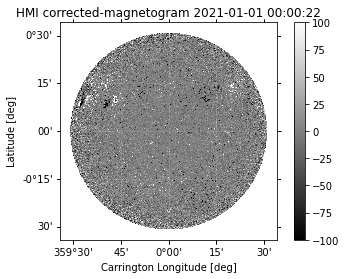

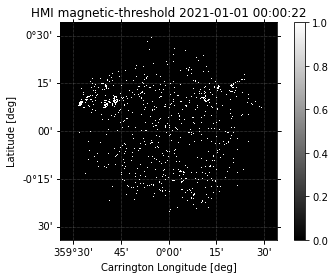

In [26]:
# plot corrected magnetic map
map_mag_cor[0].peek()

# plot corrected magnetic threshold map
map_mag_thresh[0].peek()

### Part Two: Intensity Thresholding

Differentiate between sunspots (dark) and faculae (bright).
Using method of Yeo et al. 2013 we calculate the intensity threshold such that
$ I_{thresh} = 0.89I_{quiet} $ where $ I_{quiet} = \frac{\sum_{ij} I_{flat, ij} W_{ij}}{\sum_{ij} W_{ij}} $
is the mean pixel flattened intensity over quiet Sun regions.

Calculate intensity threshold value and differentiate between sunspots and faculae where:

<code>fac_inds, spot_inds = int_thresh[0], int_thresh[1]</code>

In [27]:
int_thresh = [sfuncs.int_thresh(map_int_cor[i], mag_thresh[i][0], mag_thresh[i][1]) for i in range(0, len(hmi_int))]

Create list of Sunpy map objects with faculae and sunspot data.

In [28]:
# create faculae map objects
fac_map = [sfuncs.corrected_map(int_thresh[i][0], hmi_mag[i], map_type='Faculae', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_int))]

# create sunspot map objects
spot_map = [sfuncs.corrected_map(int_thresh[i][1], hmi_mag[i], map_type='Sunspot', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_int))]

Compare original and corrected threshold maps.

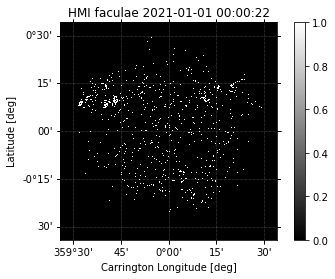

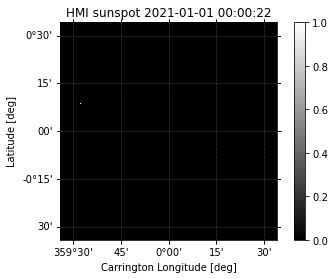

In [29]:
# plot faculae map
fac_map[0].peek()

# plot sunspot map
spot_map[0].peek()

Create array that combines sunspot (dark: 2) and faculae (bright: 1) regions.


In [30]:
thresh_arr = [sfuncs.thresh_map(int_thresh[i][0], int_thresh[i][1]) for i in range(0, len(hmi_mag))]


Create list of Sunpy map objects with threshold data.

In [31]:
# create threshold map objects
map_full_thresh = [sfuncs.corrected_map(thresh_arr[i], hmi_mag[i], map_type='Threshold', frame=frames.HeliographicCarrington) for i in range(0, len(hmi_int))]

Compare corrected magnetic and threshold maps

For these threshold maps, we currently only see sunspots detected on the solar
limb. The solar limb is inherently darker (limb darkening) and since we have yet
to correct for this it is expected that the overall intensity threshold is lower
and thus the only values below this threshold are on the limb.

The Sun is also not currently super magnetically active (solar minima) in the
time I plotted so this makes sense that there are not many sunspots.

Could also adjust the $ \mu $ cutoff value to remove these sunspots, but I think limb brightening will fix it.

Text(0.5, 1.0, 'Comparison of faculae (blue) and sunspots (red) to magnetic data')

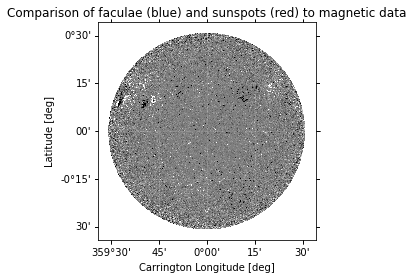

In [32]:
mag_map = map_mag_cor[0]
mag_map.plot_settings['norm'] = plt.Normalize(-100, 100)
mag_map.plot()
plt.imshow(map_full_thresh[0].data, cmap=plt.get_cmap('bwr'))
plt.title("Comparison of faculae (blue) and sunspots (red) to magnetic data")

Text(0.5, 1.0, 'Comparison of faculae (blue) and sunspots (red) to intensity data')

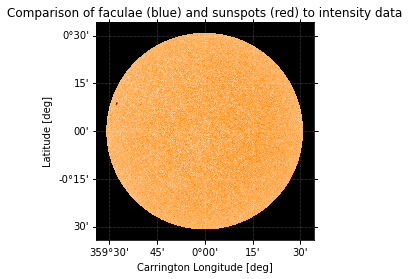

In [33]:
int_map = map_int_cor[0]
cont_map = plt.get_cmap('hinodesotintensity')
int_map.plot_settings['cmap'] = cont_map
int_map.plot()
plt.imshow(map_full_thresh[0].data, cmap=plt.get_cmap('bwr'))
plt.title("Comparison of faculae (blue) and sunspots (red) to intensity data")

Text(0.5, 1.0, 'Comparison of sunspots to intensity data')

/Users/tervin/opt/anaconda3/envs/sdo_hmi_rvs/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/tervin/opt/anaconda3/envs/sdo_hmi_rvs/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
/Users/tervin/opt/anaconda3/envs/sdo_hmi_rvs/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/tervin/opt/anaconda3/envs/sdo_hmi_rvs/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


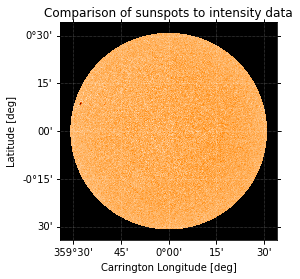

In [34]:
int_map = map_int_cor[0]
cont_map = plt.get_cmap('hinodesotintensity')
int_map.plot_settings['cmap'] = cont_map
int_map.plot()

spots = np.where(map_full_thresh[0].data == 2, 1, np.nan)
plt.imshow(spots, cmap='Blues')
plt.title("Comparison of sunspots to intensity data")

# Outline of Calculations of Solar RVs

1. **quiet-Sun velocity:** estimation of average RV of quiet-Sun due to convective motion
2. **photometric velocity:** estimation of rotational Doppler imbalance due to active (faculae/darkspot) regions
3. **convective blueshift:** convective velocity estimation due to the suppression of the convective blueshift by
magnetically active regions


## Step One: Convective Motion of quiet-Sun

Calculate the velocity due to the convective motion of the quiet-Sun. Requires
the magnetic weighting array we built in step six, part one. A weight of 0 denotes an
active pixel, and 1 is quiet-Sun.

The equation for calculating this quiet-Sun velocity is as such:
$ v_{quiet} = \frac{\sum_{ij} (v_{ij} - \delta v_{sc, ij} - \delta v_{rot, ij}) I_{ij} W_{ij}}
 {\sum_{ij} I_{ij} W_{ij}} $.

In this case $ I_{ij} $ is the uncorrected (original) intensity data.

In [35]:
v_quiet = [sfuncs.v_quiet(map_vel_cor[i], hmi_int[i], mag_thresh[i][1]) for i in range(0, len(hmi_mag))]

## Step Two: Photometric Velocity due to rotational Doppler imbalance

Calculation of the photometric velocity due the presence of dark spots/bright faculae causing a Doppler imbalance. Requires
magnetic weighting array that is flipped from the weighting array previously used. Now, a weight of 0 denotes quiet-Sun and
1 denotes active pixel.

The equation for this velocity calculation is:
$ v_{phot} = \frac{\sum_{ij} (v_{ij} - \delta v_{rot, ij})(I_{ij} - K) W_{ij}}
 {\sum_{ij} I_{ij}} $.

K is a scaling factor based off the limb-brightening correction carried out in Step Four of the solar corrections.
$ K = \frac{\sum_{ij} I_{ij} L_{ij} W_{ij}}{\sum_{ij} L_{ij}^2 W_{ij}} $

In this case $ I_{ij} $ is the uncorrected (original) intensity data.

Calculate photometric velocity.

<code>v_phot, vphot_bright, vphot_spot = vphot[0], vphot[1], vphot[2]</code>

In [36]:
vphot = [sfuncs.v_phot(mag_thresh[i][1], mag_thresh[i][0], Lij[i], vrot[i], hmi_int[i], coord[i][5],
                        int_thresh[i][0], int_thresh[i][1], mu_cutoff=Parameters.mu_cutoff) for i in range(0, len(hmi_int))]
v_phot = [v[0] for v in vphot]

## Step Three: Convective Blueshift Velocity

Calculation of suppression of convective blueshift due to active regions (mainly faculae).

The basic premise for calculation is to calculate the disc-averaged velocity of the Sun
and subtract from that the quiet-Sun velocity (Step One) and photometric velocity (Step Two) both of which were
calculated previously.

The equation for the disc-averaged velocity is:
$ v = \frac{\sum_{ij} (v_{ij} - \delta v_{sc, ij} - \delta v_{rot, ij}) I_{ij}}{\sum_{ij} I_{ij}} $

We then calculate the convective velocity as what is left:
$ v_{conv} = v - v_{quiet} $

Calculate disc-averaged velocity of Sun.

In [37]:
v_disc = [sfuncs.v_disc(map_vel_cor[i], hmi_int[i]) for i in range(0, len(hmi_int))]

Calculate convective velocity.

In [38]:
v_conv = [v_disc[i] - v_quiet[i] for i in range(0, len(hmi_mag))]

# Magnetic Observables

Calculation of relevant magnetic observables.

1. **filling factor:** disc averaged filling factors of sunspots and plage which gives
the percentage of magnetically active pixels
2. **unsigned magnetic flux:** calculation of disc-averaged, line-of-sight unsigned
magnetic flux

## Filling Factor

Estimate the disc-averaged filling factors of sunspots and plage:
$ f_{spot, plage} = \frac{1}{N_{pix}} \sum_{ij} W_{ij} $

In this case, a weight of 1 is an active pixel (active_weights).

<code>f_bright, f_spot, f = filling[0], filling[1], filling[2]</code>

In [39]:
filling = [sfuncs.filling_factor(coord[i][5], hmi_mag[i], mag_thresh[i][0], int_thresh[i][0], int_thresh[i][1], mu_cutoff=Parameters.mu_cutoff)
           for i in range(0, len(hmi_mag))]


## Unsigned Magnetic Flux

Calculate disc-averaged, line-of-sight unsigned (unpolarized) magnetic flux of the Sun.

Calculation of observed unsigned flux.

$ |\hat{B_{obs}}| = \frac{\sum_{ij} |B_{obs, ij}| I_{ij}} {\sum_{ij} I_{ij}}$

In [40]:
unsigned_obs_flux = [sfuncs.unsigned_flux(map_mag_obs[i], hmi_int[i]) for i in range(0, len(hmi_mag))]

## Area Based Observable Calculations

Calculate intensity weighted area of each active region.

In [41]:
pixA_hem = [ctfuncs.pix_area_hem(vel_coords[i][0], vel_coords[i][1], vel_coords[i][2], hmi_vel[i]) for i in range(0, len(hmi_vel))]
area = [sfuncs.area_calc(mag_thresh[i][0], pixA_hem[i]) for i in range(0, len(hmi_vel))]

Calculate the area filling factor.

<code>f_small, f_large, f_network, f_plage = f_area[0], f_area[1], f_area[2], f_area[3]</code>

In [42]:
f_area = [sfuncs.area_filling_factor(mag_thresh[i][0], area[i], coord[i][5], hmi_mag[i], int_thresh[i][0], athresh=Parameters.athresh,
                     mu_cutoff=Parameters.mu_cutoff) for i in range(0, len(hmi_mag))]

Calculate unsigned flux of various polarized and active regions.

<code>quiet_flux, ar_flux, conv_flux, pol_flux, pol_conv_flux = flux[0], flux[1], flux[2], flux[3], flux[4], flux[5]</code>

In [43]:
flux = [sfuncs.area_unsigned_flux(map_mag_obs[i], hmi_int[i],
                                area[i], int_thresh[i][0], athresh=Parameters.athresh) for i in range(0, len(hmi_int))]

Get area weighted convective velocities.

<code>vconv_quiet, vconv_large, vconv_small = vconv_area[0], vconv_area[1], vconv_area[2]</code>

In [44]:
vconv_area = [sfuncs.area_vconv(map_vel_cor[i], hmi_int[i], int_thresh[i][0], area[i], athresh=Parameters.athresh) for i in range(0, len(hmi_int))]

# Plotting of Relevant Observables

Make days array and list for plotting uses.

In [45]:
# make array of days
days_list = [hmi_mag[i].meta['date-obs'] for i in range(0, len(hmi_mag))]
days_range = range(0, len(days_list))

## Magnetic Observables: Comparison of filling factor and unsigned magnetic flux

Plot filling factor and unsigned observed flux over time.

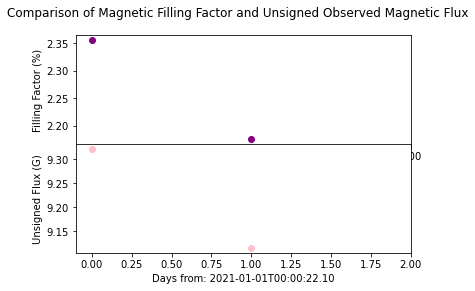

In [46]:
# convert filling factor to a percent
f = [f[2] for f in filling]

# setup the plot
fig, axs = plt.subplots(2, 1, sharex='all', gridspec_kw={'hspace':0})
fig.suptitle("Comparison of Magnetic Filling Factor and Unsigned Observed Magnetic Flux")
axs[0].set(ylabel='Filling Factor (%)')
axs[1].set(xlabel='Days from: ' + str(days_list[0]) , ylabel='Unsigned Flux (G)')

# plot data
axs[0].scatter(days_range, f, color='purple', label='Filling Factor')
axs[1].scatter(days_range, unsigned_obs_flux, color='pink', label='Unsigned Flux')

for ax in axs:
    ax.set_xlim([-0.1, len(days_list)])
    ax.tick_params(labelbottom=True)


## Velocity Components: Comparison of photometic and convective velocities

Comparison plot comparing the photometric and convective velocities found
in steps two and three of RV calculations.

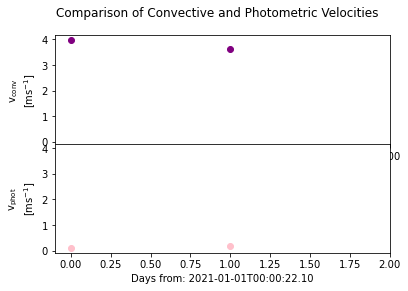

In [47]:
# setup the plot
fig, axs = plt.subplots(2, 1, sharex='all', sharey='all', gridspec_kw={'hspace':0})
fig.suptitle("Comparison of Convective and Photometric Velocities")
axs[0].set(ylabel=r'$\rm v_{conv}$' '\n' r'$\rm[m s^{-1}]$')
axs[1].set(xlabel='Days from: ' + str(days_list[0]) , ylabel=r'$\rm v_{phot}$' '\n' r'$\rm[m s^{-1}]$')

# plot data
axs[0].scatter(days_range, v_conv, color='purple', label=r'$\rm v_{conv}$')
axs[1].scatter(days_range, v_phot, color='pink', label=r'$\rm v_{phot}$')

for ax in axs:
    ax.set_xlim([-0.1, len(days_list)])
    ax.tick_params(labelbottom=True)


## Correlation plot between convective velocity and magnetic observables

Plot comparing convective velocity with magnetic filling factor and unsigned
magnetic flux. Spearman correlation coefficients are calculated. This coefficient
is chosen because it looks for a monotonic relationship that may not be linear.

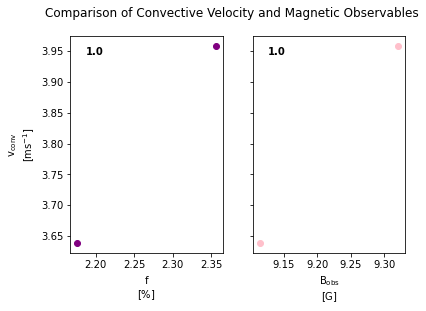

In [48]:
# calculate correlation coefficient
fac_correlation = stats.spearmanr(f, v_conv)
flux_correlation = stats.spearmanr(unsigned_obs_flux, v_conv)

# setup the plot
fig, axs = plt.subplots(1, 2, sharey='all', gridspec_kw={'hspace':0})
fig.suptitle("Comparison of Convective Velocity and Magnetic Observables")
axs[0].set(xlabel=r'$\rm f$' '\n' r'$\rm$[%]', ylabel=r'$\rm v_{conv}$' '\n' r'$\rm[m s^{-1}]$')
axs[1].set(xlabel=r'$\rm B_{\rm obs}$' '\n' r'$\rm [G]$')

# plot data
axs[0].scatter(f, v_conv, color='purple', label='Filling Factor')
axs[1].scatter(unsigned_obs_flux, v_conv, color='pink', label='Unsigned Observed Flux')

# label correlation coefficients
axs[0].text(0.1, 0.95, str(np.around(fac_correlation[0], 2)), horizontalalignment='left',
      verticalalignment='top', transform=axs[0].transAxes, weight='bold')
axs[1].text(0.1, 0.95, str(np.around(flux_correlation[0], 2)), horizontalalignment='left',
      verticalalignment='top', transform=axs[1].transAxes, weight='bold')

for ax in axs:
    ax.tick_params(labelbottom=True)


## Plot relating LOS magnetic field to flattened intensity

Plot showing observed line of sight (unsigned) magnetic field as a
function of flattened intensity (corrected for limb darkening). The histograms
show the distributions of the respective observables.

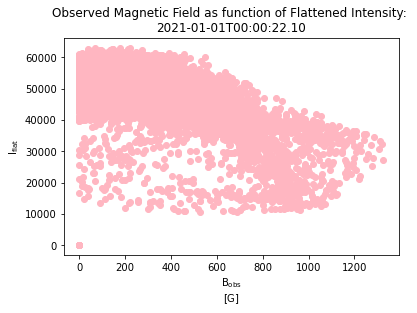

In [49]:
plt.title("Observed Magnetic Field as function of Flattened Intensity: \n" +
          str(hmi_mag[0].meta['date-obs']))
plt.xlabel(r'$\rm B_{\rm obs}$' '\n' r'$\rm [G]$')
plt.ylabel(r'$\rm I_{\rm flat}$')

# plot non-active pixels in black
i = 0
x = np.abs(map_mag_obs[0].data)
y = Iflat[0]

plt.scatter(x, y, color='lightpink')

# # horizontal intensity threshold line
# plt.hlines(int_thresh[i][0], xmin=x.min(), xmax=x.max(), colors='purple', linestyles='dashed')
#
# # vertical magnetic threshold line
# plt.vlines(mag_thresh[i][1], ymin=y.min(), ymax=y.max(), colors='blue', linestyles='dashed')
#

